## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

## Let's start the coding with dependency Library imports along with some basic checks for GPU and ploting methods defition

**Note: I have used Google colab and my lab GPU enabled server for the code excution. So, the exution report is mix of both the executions** 

In [ ]:
## Checking the GPU configuration

!nvidia-smi

Fri Aug 19 13:51:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 455.23.05    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   72C    P0    57W / 250W |    129MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  On   | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [ ]:
# Importing the necessary libraries

import numpy as np
from skimage import io
from skimage.transform import rescale, resize
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [ ]:
np.random.seed(142)
import random as rn
rn.seed(142)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(142)

In [ ]:
import cv2
import matplotlib.pyplot as plt
#% matplotlib inline

In [ ]:
# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, LSTM
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
project_folder='/root/abh/Project_data'

##### Plotting

In [ ]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])   
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")
    plt.show()

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=128,image_width=128):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=32,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.process_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.process_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def process_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = io.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resized=resize(image,(self.image_height,self.image_width,3))
            
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                        
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])
        
        return(batch_data,batch_labels)
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

In [ ]:
# Verifying the no of GPUs on the server
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
tf.test.is_gpu_available( cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

2022-08-19 13:53:49.031164: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 13:53:50.163079: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 30858 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2022-08-19 13:53:50.165154: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 30987 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


# Model Builing and evaluation with validation data

Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Sample Model

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = "Adam"
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 160, 160, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization (BatchN  (None, 30, 160, 160, 16)  64       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 80, 80, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 80, 80, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 80, 80, 32)    0

2022-08-19 11:42:29.110289: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30857 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2022-08-19 11:42:29.111884: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30987 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


##### Sample Cropping

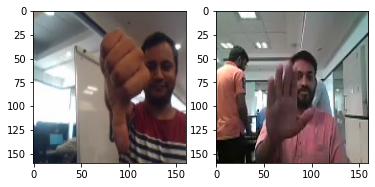

In [ ]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=32,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
conv_3d1.train_model(conv_3d1_model)

2022-08-19 11:43:20.150851: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-08-19 11:43:20.613376: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


21/21 [==============================] - ETA: 0s - loss: 1.4025 - categorical_accuracy: 0.4555
Epoch 1: val_loss improved from inf to 2.57117, saving model to model_init_2022-08-1911_43_09.795639/model-00001-1.40248-0.45551-2.57117-0.22000.h5
21/21 [==============================] - 212s 10s/step - loss: 1.4025 - categorical_accuracy: 0.4555 - val_loss: 2.5712 - val_categorical_accuracy: 0.2200 - lr: 0.0010


In [ ]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.6621095314621925 Gigs


### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=128,image_width=128)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 16, 128, 128, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 16, 128, 128, 16)  0         
                                                                 
 batch_normalization_38 (Bat  (None, 16, 128, 128, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 8, 64, 64, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 8, 64, 64, 32)     4128      
                                                                 
 activation_29 (Activation)  (None, 8, 64, 64, 32)    

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - ETA: 0s - loss: 1.7196 - categorical_accuracy: 0.3635
Epoch 1: val_loss improved from inf to 2.49563, saving model to model_init_2022-08-1806_58_32.875203/model-00001-1.71958-0.36350-2.49563-0.21000.h5
34/34 [==============================] - 153s 5s/step - loss: 1.7196 - categorical_accuracy: 0.3635 - val_loss: 2.4956 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/2
34/34 [==============================] - ETA: 0s - loss: 1.0615 - categorical_accuracy: 0.6018
Epoch 2: val_loss did not improve from 2.49563
34/34 [==============================] - 148s 4s/step - loss: 1.0615 - categorical_accuracy: 0.6018 - val_loss: 4.5435 - val_categorical_accuracy: 0.2500 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=128,image_width=128)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=128,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1146565
Epoch 1/2
6/6 [==============================] - ETA: 0s - loss: 1.7032 - categorical_accuracy: 0.3861 
Epoch 1: val_loss improved from inf to 1.59038, saving model to model_init_2022-08-1807_06_56.731917/model-00001-1.70322-0.38612-1.59038-0.19000.h5
6/6 [==============================] - 175s 34s/step - loss: 1.7032 - categorical_accuracy: 0.3861 - val_loss: 1.5904 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/2
6/6 [==============================] - ETA: 0s - loss: 0.9399 - categorical_accuracy: 0.6365 
Epoch 2: val_loss did not improve from 1.59038
6/6 [==============================] - 171s 34s/step - loss: 0.9399 - categorical_accuracy: 0.6365 - val_loss: 1.6462 - val_categorical_accuracy: 0.2300 - lr: 0.0010


In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=16,batch_size=128,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
6/6 [==============================] - ETA: 0s - loss: 1.6820 - categorical_accuracy: 0.4012 
Epoch 1: val_loss improved from inf to 1.53619, saving model to model_init_2022-08-1807_14_26.970982/model-00001-1.68202-0.40121-1.53619-0.32000.h5
6/6 [==============================] - 113s 22s/step - loss: 1.6820 - categorical_accuracy: 0.4012 - val_loss: 1.5362 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 2/2
6/6 [==============================] - ETA: 0s - loss: 0.9432 - categorical_accuracy: 0.6456 
Epoch 2: val_loss did not improve from 1.53619
6/6 [==============================] - 110s 22s/step - loss: 0.9432 - categorical_accuracy: 0.6456 - val_loss: 1.7289 - val_categorical_accuracy: 0.2100 - lr: 0.0010


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 32-64-128 as my server is allowing that amount of memory usages
- We will change the resoulution 100*100, 160-160, 128-128 according the model performance
- I have also experimented with different batch size and different frame size. 
  - When I ran my code on colab, with batch size as 64, I got OOM error. Then I run it with batch size 32 on google colab
  - When I ran in my lab server, I was able to run with 64 batch size, as server has more GPU memory
  - The Number of frames has impact on execution time per epoch. If the epoch size is 30 then it is very time consuming, but results(accuracy) doesn't have that much impact. This is a trad-off between time and accuracy. We I have used mostly 20 frames for experiments.
  - Also the resolution seems to be fine with 120*120, 128*128 and 160*160 


## Let's experiment with different CNN3D models having diffrenet number of train parameters and different layer architecture



### Model - 0 
- frames_to_sample=30,batch_size=64,num_epochs=5

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'Adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=64,num_epochs=5)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 160, 160, 16)  1312      
                                                                 
 activation_8 (Activation)   (None, 30, 160, 160, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 80, 80, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 80, 80, 32)    13856     
                                                                 
 activation_9 (Activation)   (None, 15, 80, 80, 32)   

In [ ]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/5


ResourceExhaustedError: ignored

### Model 1  
### Adding dropout layers - Batch Size = 64 and No. of Epochs = 25

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'Adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_56 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_56 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_80 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_56 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 10, 80, 80, 16)    0         
                                                                 
 conv3d_57 (Conv3D)          (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 2.2093 - categorical_accuracy: 0.3107 WARNING:tensorflow:5 out of the last 17 calls to <function Model.make_test_function.<locals>.test_function at 0x7fc9c41e9b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.

Epoch 1: val_loss improved from inf to 2.29559, saving model to model_init_2022-08-1807_38_20.936885/model-00001-2.20926-0.31071-2.29559-0.2

Epoch 22/25
11/11 [==============================] - ETA: 0s - loss: 0.7592 - categorical_accuracy: 0.7187 
Epoch 22: val_loss did not improve from 2.20823

Epoch 22: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
11/11 [==============================] - 246s 24s/step - loss: 0.7592 - categorical_accuracy: 0.7187 - val_loss: 4.5809 - val_categorical_accuracy: 0.3200 - lr: 1.6000e-06
Epoch 22: early stopping


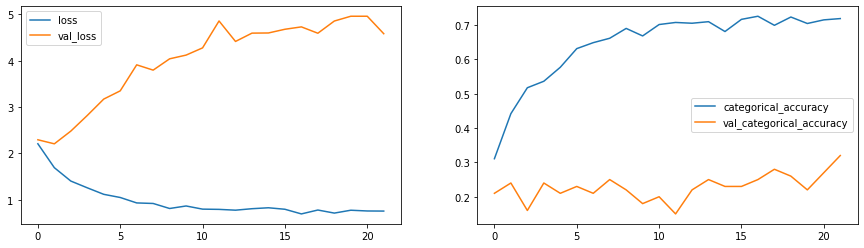

In [ ]:
plot(history_model2)

##### We can see  val_loss did not improve from 1.24219 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 22/25!! good job earlystopping ;)
- Best weights save automatically. The validation accuracy of 32% and training accuracy of 72%. Clearly we are overfitting

### Model - 2

### Removing the batch normalization layers

### Base Model - Batch size - 32, Frames - 20, epochs-10

In [ ]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        #model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = 'Adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=120,image_width=120)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=32,num_epochs=10)
conv_3d2_model=conv_3d2.define_model()
conv_3d2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_16 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 10, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 10, 60, 60, 32)    13856     
                                                                 
 activation_17 (Activation)  (None, 10, 60, 60, 32)    0         
                                                                 
 max_pooling3d_17 (MaxPoolin  (None, 5, 30, 30, 32)    0         
 g3D)                                                 

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2 = conv_3d2.train_model(conv_3d2_model)

Total Params: 697797
Epoch 1/10
21/21 [==============================] - ETA: 0s - loss: 1.6213 - categorical_accuracy: 0.1946
Epoch 1: val_loss improved from inf to 1.60736, saving model to model_init_2022-08-1814_00_55.479178/model-00001-1.62126-0.19457-1.60736-0.23000.h5
21/21 [==============================] - 195s 10s/step - loss: 1.6213 - categorical_accuracy: 0.1946 - val_loss: 1.6074 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/10
21/21 [==============================] - ETA: 0s - loss: 1.6063 - categorical_accuracy: 0.2051
Epoch 2: val_loss improved from 1.60736 to 1.58378, saving model to model_init_2022-08-1814_00_55.479178/model-00002-1.60627-0.20513-1.58378-0.22000.h5
21/21 [==============================] - 187s 9s/step - loss: 1.6063 - categorical_accuracy: 0.2051 - val_loss: 1.5838 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/10
21/21 [==============================] - ETA: 0s - loss: 1.5489 - categorical_accuracy: 0.2685
Epoch 3: val_loss improved

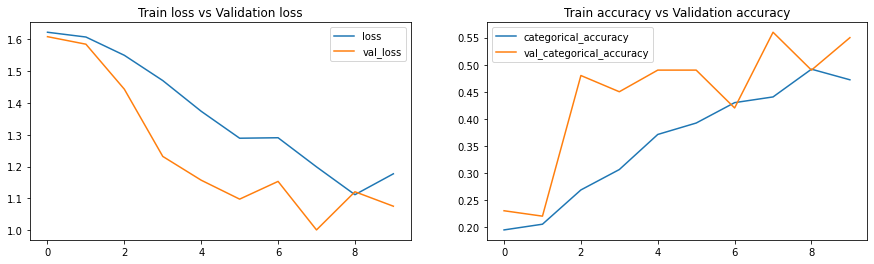

Max. Training Accuracy 0.49170437455177307
Max. Validaiton Accuracy 0.5600000023841858


In [ ]:
plotModelHistory(history_model2)

##### Model needs more training epochs. But we are on right track as loss functionas are behaving correctly that can be confirmed from above result

### Model 3 
### Reduce filter size to (2,2,2) and image res to 120 x  120, - Batch Size = 32 and No. of Epochs = 25

In [ ]:
class ModelConv3D3(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = "Adam"
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
conv_3d3=ModelConv3D3()
conv_3d3.initialize_path(project_folder)
conv_3d3.initialize_image_properties(image_height=120,image_width=120)
conv_3d3.initialize_hyperparams(frames_to_sample=16,batch_size=32,num_epochs=25)
conv_3d3_model=conv_3d3.define_model(filtersize=(2,2,2),dense_neurons=256,dropout=0.5)
conv_3d3_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_68 (Conv3D)          (None, 16, 120, 120, 16)  400       
                                                                 
 activation_68 (Activation)  (None, 16, 120, 120, 16)  0         
                                                                 
 max_pooling3d_68 (MaxPoolin  (None, 8, 60, 60, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_69 (Conv3D)          (None, 8, 60, 60, 32)     4128      
                                                                 
 activation_69 (Activation)  (None, 8, 60, 60, 32)     0         
                                                                 
 max_pooling3d_69 (MaxPoolin  (None, 4, 30, 30, 32)    0         
 g3D)                                                

In [ ]:
print("Total Params:", conv_3d3_model.count_params())
history_model3=conv_3d3.train_model(conv_3d3_model,augment_data=True)

Total Params: 1759605
Epoch 1/25
21/21 [==============================] - ETA: 0s - loss: 1.6123 - categorical_accuracy: 0.2066
Epoch 1: val_loss improved from inf to 1.58247, saving model to model_init_2022-08-1809_42_30.786898/model-00001-1.61234-0.20664-1.58247-0.23000.h5
21/21 [==============================] - 161s 8s/step - loss: 1.6123 - categorical_accuracy: 0.2066 - val_loss: 1.5825 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
21/21 [==============================] - ETA: 0s - loss: 1.5935 - categorical_accuracy: 0.2187
Epoch 2: val_loss improved from 1.58247 to 1.52801, saving model to model_init_2022-08-1809_42_30.786898/model-00002-1.59350-0.21870-1.52801-0.26000.h5
21/21 [==============================] - 158s 8s/step - loss: 1.5935 - categorical_accuracy: 0.2187 - val_loss: 1.5280 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
21/21 [==============================] - ETA: 0s - loss: 1.5181 - categorical_accuracy: 0.2851
Epoch 3: val_loss improved

Epoch 21/25
21/21 [==============================] - ETA: 0s - loss: 0.1698 - categorical_accuracy: 0.9382
Epoch 21: val_loss improved from 0.33437 to 0.29691, saving model to model_init_2022-08-1809_42_30.786898/model-00021-0.16977-0.93816-0.29691-0.91000.h5
21/21 [==============================] - 159s 8s/step - loss: 0.1698 - categorical_accuracy: 0.9382 - val_loss: 0.2969 - val_categorical_accuracy: 0.9100 - lr: 2.0000e-04
Epoch 22/25
21/21 [==============================] - ETA: 0s - loss: 0.1488 - categorical_accuracy: 0.9532
Epoch 22: val_loss did not improve from 0.29691
21/21 [==============================] - 158s 8s/step - loss: 0.1488 - categorical_accuracy: 0.9532 - val_loss: 0.3201 - val_categorical_accuracy: 0.9300 - lr: 2.0000e-04
Epoch 23/25
21/21 [==============================] - ETA: 0s - loss: 0.1384 - categorical_accuracy: 0.9548
Epoch 23: val_loss improved from 0.29691 to 0.22218, saving model to model_init_2022-08-1809_42_30.786898/model-00023-0.13838-0.95475-0.

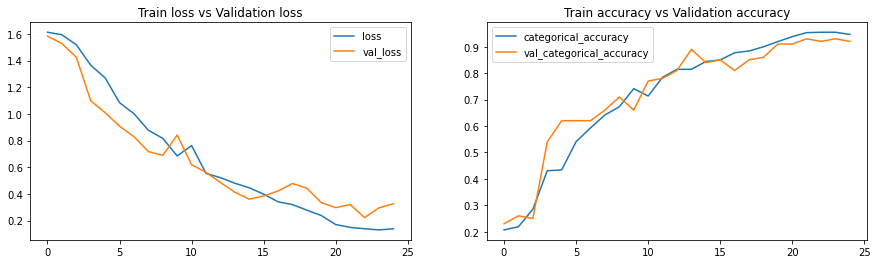

Max. Training Accuracy 0.9547511339187622
Max. Validaiton Accuracy 0.9300000071525574


In [ ]:
plotModelHistory(history_model3)

##### Model has a  best validation accuracy of 93% and training accuracy of 95.47% . Also we were able to reduce the parameter size by half the earlier model. Let's trying adding more layers

##### Running the CNN network with less number of parameters by decresing the dense_neurons=128 

### **Model - 4** 
- frames_to_sample=16, batch_size=64, num_epochs=50

In [ ]:
conv_3d4=ModelConv3D3()
conv_3d4.initialize_path(project_folder)
conv_3d4.initialize_image_properties(image_height=128,image_width=128)
conv_3d4.initialize_hyperparams(frames_to_sample=16,batch_size=64,num_epochs=50)
conv_3d4_model=conv_3d4.define_model(filtersize=(2,2,2),dense_neurons=64,dropout=0.5)
conv_3d4_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 16, 128, 128, 16)  400       
                                                                 
 activation (Activation)     (None, 16, 128, 128, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 8, 64, 64, 16)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 64, 64, 32)     4128      
                                                                 
 activation_1 (Activation)   (None, 8, 64, 64, 32)     0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 32, 32, 32)    0         
 3D)                                                    

2022-08-19 13:55:28.160959: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30858 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
2022-08-19 13:55:28.162558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30987 MB memory:  -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:d8:00.0, compute capability: 7.0


In [ ]:
print("Total Params:", conv_3d4_model.count_params())
history_model4=conv_3d4.train_model(conv_3d4_model,augment_data=True)

Total Params: 615477
Epoch 1/50


2022-08-19 13:56:23.299301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204
2022-08-19 13:56:23.752379: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


11/11 [==============================] - ETA: 0s - loss: 1.6185 - categorical_accuracy: 0.2044 
Epoch 1: val_loss improved from inf to 1.60673, saving model to model_init_2022-08-1913_56_06.056336/model-00001-1.61846-0.20437-1.60673-0.26000.h5
11/11 [==============================] - 166s 16s/step - loss: 1.6185 - categorical_accuracy: 0.2044 - val_loss: 1.6067 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.6049 - categorical_accuracy: 0.2164 
Epoch 2: val_loss improved from 1.60673 to 1.59608, saving model to model_init_2022-08-1913_56_06.056336/model-00002-1.60491-0.21644-1.59608-0.19000.h5
11/11 [==============================] - 160s 16s/step - loss: 1.6049 - categorical_accuracy: 0.2164 - val_loss: 1.5961 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.5966 - categorical_accuracy: 0.2195 
Epoch 3: val_loss improved from 1.59608 to 1.57852, sa

11/11 [==============================] - 164s 16s/step - loss: 0.6819 - categorical_accuracy: 0.7338 - val_loss: 0.4622 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 22/50
11/11 [==============================] - ETA: 0s - loss: 0.6894 - categorical_accuracy: 0.7323 
Epoch 22: val_loss did not improve from 0.46217
11/11 [==============================] - 158s 16s/step - loss: 0.6894 - categorical_accuracy: 0.7323 - val_loss: 0.5222 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 23/50
11/11 [==============================] - ETA: 0s - loss: 0.6178 - categorical_accuracy: 0.7753 
Epoch 23: val_loss improved from 0.46217 to 0.39381, saving model to model_init_2022-08-1913_56_06.056336/model-00023-0.61782-0.77526-0.39381-0.88000.h5
11/11 [==============================] - 162s 16s/step - loss: 0.6178 - categorical_accuracy: 0.7753 - val_loss: 0.3938 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 24/50
11/11 [==============================] - ETA: 0s - loss: 0.5987 - c

Epoch 44/50
11/11 [==============================] - ETA: 0s - loss: 0.3133 - categorical_accuracy: 0.8831 
Epoch 44: val_loss did not improve from 0.12430
11/11 [==============================] - 158s 16s/step - loss: 0.3133 - categorical_accuracy: 0.8831 - val_loss: 0.2239 - val_categorical_accuracy: 0.9100 - lr: 4.0000e-05
Epoch 45/50
11/11 [==============================] - ETA: 0s - loss: 0.3136 - categorical_accuracy: 0.8771 
Epoch 45: val_loss did not improve from 0.12430
11/11 [==============================] - 163s 16s/step - loss: 0.3136 - categorical_accuracy: 0.8771 - val_loss: 0.2153 - val_categorical_accuracy: 0.9000 - lr: 4.0000e-05
Epoch 46/50
11/11 [==============================] - ETA: 0s - loss: 0.2992 - categorical_accuracy: 0.8861 
Epoch 46: val_loss did not improve from 0.12430

Epoch 46: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
11/11 [==============================] - 159s 16s/step - loss: 0.2992 - categorical_accuracy: 0.8861 - val_los

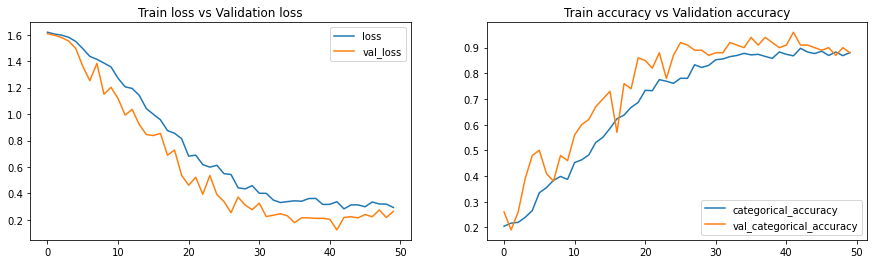

Max. Training Accuracy 0.8974359035491943
Max. Validaiton Accuracy 0.9599999785423279


In [ ]:
plotModelHistory(history_model4)

**Let's do a comaprision between two best models 3 and 4 till now**

- Model 3 - **conv_3d3** 
  - The Total Params: 1759605 . 
  - The size of the model was ~ 20 MB
  - The number of iteration it ran was only 25
  - Max Train accuracy was 95%
  - Max Validation accuracy was 93%

- Model 4 - **conv_3d4** 
  - The Total Params: 615477, which almost three times lesser than the erlier model. 
  - The new model size is ~ 7 MB, so this ligher as well. Which will do faster prediction as well. 
  - The number of training iteration was 50. So it took nearly 3 hours to train.
  - Max Train accuracy was 90%
  - Max validation accuracy was 96%
  - I had run the same experiment with 25 iterations well. There I got the indication that val loss is going down using and I can train it further to get better validation accuracy. I

- So till now the best model is Model 4 - **cov_3d4** 

## Let's try CNN + RNN with different RNN varients and different type of layer



### Model 5 - CNN- LSTM Model

In [ ]:
class RNN_CNN(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = 'Adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn1=RNN_CNN()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 30, 30, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 30, 30, 64) 

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model6=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1655461
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6200 - categorical_accuracy: 0.2097 
Epoch 1: val_loss improved from inf to 1.60422, saving model to model_init_2022-08-1812_19_16.524633/model-00001-1.61996-0.20965-1.60422-0.23000.h5
11/11 [==============================] - 201s 20s/step - loss: 1.6200 - categorical_accuracy: 0.2097 - val_loss: 1.6042 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.6044 - categorical_accuracy: 0.2119 
Epoch 2: val_loss improved from 1.60422 to 1.58799, saving model to model_init_2022-08-1812_19_16.524633/model-00002-1.60443-0.21192-1.58799-0.17000.h5
11/11 [==============================] - 189s 19s/step - loss: 1.6044 - categorical_accuracy: 0.2119 - val_loss: 1.5880 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.5711 - categorical_accuracy: 0.2436 
Epoch 3: val_loss imp

11/11 [==============================] - 195s 19s/step - loss: 0.0713 - categorical_accuracy: 0.9811 - val_loss: 0.5498 - val_categorical_accuracy: 0.8200 - lr: 2.0000e-04
Epoch 22/25
11/11 [==============================] - ETA: 0s - loss: 0.0527 - categorical_accuracy: 0.9857 
Epoch 22: val_loss did not improve from 0.50314
11/11 [==============================] - 190s 19s/step - loss: 0.0527 - categorical_accuracy: 0.9857 - val_loss: 0.6093 - val_categorical_accuracy: 0.8100 - lr: 2.0000e-04
Epoch 23/25
11/11 [==============================] - ETA: 0s - loss: 0.0443 - categorical_accuracy: 0.9864 
Epoch 23: val_loss did not improve from 0.50314

Epoch 23: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
11/11 [==============================] - 197s 20s/step - loss: 0.0443 - categorical_accuracy: 0.9864 - val_loss: 0.6282 - val_categorical_accuracy: 0.8100 - lr: 2.0000e-04
Epoch 24/25
11/11 [==============================] - ETA: 0s - loss: 0.0290 - categorical_acc

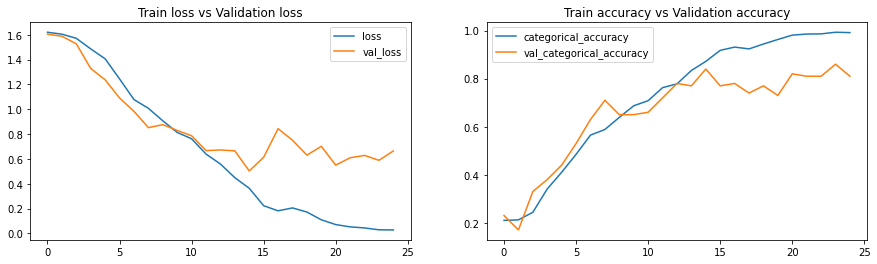

Max. Training Accuracy 0.9932126402854919
Max. Validaiton Accuracy 0.8600000143051147


In [ ]:
plotModelHistory(history_model6)

##### We get the overfitted model. The train accuracy has gone up to 99.3% and validation accuracy is at 86% only

##### Let's increase the dropout value to 0.5 from 0.25 and see the impact.

### Model - 6

In [ ]:
rnn_cnn2=RNN_CNN()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
rnn_cnn2_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_11 (TimeDi  (None, 20, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_12 (TimeDi  (None, 20, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 20, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 20, 30, 30, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 20, 30, 30, 64) 

In [ ]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model7=rnn_cnn2.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1655461
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 0.0269 - categorical_accuracy: 0.9910 
Epoch 1: val_loss improved from inf to 0.66516, saving model to model_init_2022-08-1813_48_50.088554/model-00001-0.02693-0.99095-0.66516-0.81000.h5
11/11 [==============================] - 196s 19s/step - loss: 0.0269 - categorical_accuracy: 0.9910 - val_loss: 0.6652 - val_categorical_accuracy: 0.8100 - lr: 4.0000e-05
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 0.0281 - categorical_accuracy: 0.9925 
Epoch 2: val_loss improved from 0.66516 to 0.42273, saving model to model_init_2022-08-1813_48_50.088554/model-00002-0.02810-0.99246-0.42273-0.84000.h5
11/11 [==============================] - 189s 19s/step - loss: 0.0281 - categorical_accuracy: 0.9925 - val_loss: 0.4227 - val_categorical_accuracy: 0.8400 - lr: 4.0000e-05
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 0.0249 - categorical_accuracy: 0.9940 
Epoch 3: val_

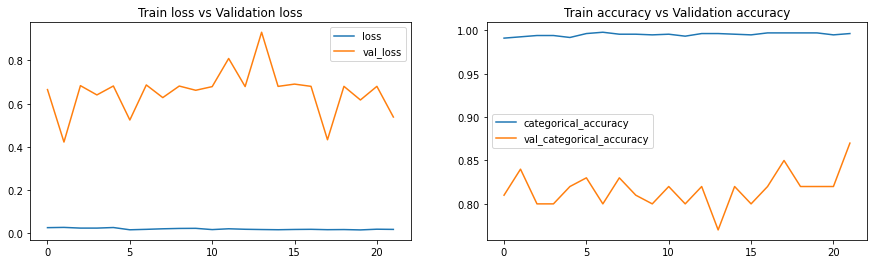

Max. Training Accuracy 0.9977375268936157
Max. Validaiton Accuracy 0.8700000047683716


In [ ]:
plotModelHistory(history_model7)

##### Again there is clear overfitting.  

##### For CNN - LSTM model we get a best validation accuracy of 87%

##### Let's try CNN - GRU as well. 

### Model 7 
### CNN RNN with GRU -- Adding extra dropout layer as well after CNN layers

In [ ]:
class RNNCNN2(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.5):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Dropout(dropout)))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = 'Adam'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [ ]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=20,batch_size=64,num_epochs=25)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.5)
rnn_cnn2_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 30, 30, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 30, 30, 64)  

In [ ]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model10=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2572965
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 1.6177 - categorical_accuracy: 0.2172 
Epoch 1: val_loss improved from inf to 1.59341, saving model to model_init_2022-08-1818_29_41.217571/model-00001-1.61770-0.21719-1.59341-0.23000.h5
11/11 [==============================] - 197s 19s/step - loss: 1.6177 - categorical_accuracy: 0.2172 - val_loss: 1.5934 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.5997 - categorical_accuracy: 0.2278 
Epoch 2: val_loss improved from 1.59341 to 1.53877, saving model to model_init_2022-08-1818_29_41.217571/model-00002-1.59966-0.22775-1.53877-0.22000.h5
11/11 [==============================] - 188s 19s/step - loss: 1.5997 - categorical_accuracy: 0.2278 - val_loss: 1.5388 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/25
11/11 [==============================] - ETA: 0s - loss: 1.5402 - categorical_accuracy: 0.3069 
Epoch 3: val_loss imp

Epoch 22/25
11/11 [==============================] - ETA: 0s - loss: 0.0478 - categorical_accuracy: 0.9910 
Epoch 22: val_loss did not improve from 0.36200
11/11 [==============================] - 187s 19s/step - loss: 0.0478 - categorical_accuracy: 0.9910 - val_loss: 0.7167 - val_categorical_accuracy: 0.8000 - lr: 2.0000e-04
Epoch 23/25
11/11 [==============================] - ETA: 0s - loss: 0.0443 - categorical_accuracy: 0.9872 
Epoch 23: val_loss did not improve from 0.36200
11/11 [==============================] - 191s 19s/step - loss: 0.0443 - categorical_accuracy: 0.9872 - val_loss: 0.6538 - val_categorical_accuracy: 0.8500 - lr: 2.0000e-04
Epoch 24/25
11/11 [==============================] - ETA: 0s - loss: 0.0383 - categorical_accuracy: 0.9917 
Epoch 24: val_loss did not improve from 0.36200

Epoch 24: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
11/11 [==============================] - 186s 19s/step - loss: 0.0383 - categorical_accuracy: 0.9917 - val_lo

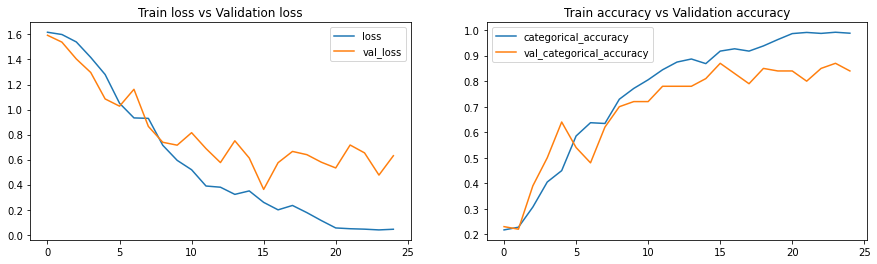

Max. Training Accuracy 0.9917043447494507
Max. Validaiton Accuracy 0.8700000047683716


In [ ]:
plotModelHistory(history_model10)

## After doing all the experiments, we finalized **Model-4(conv_3d4)** - CNN3D, which performed well.
__Reason:__

__- (Max Training Accuracy : 90%, Max Validation Accuracy : 96%)__

__- Number of Trainable Parameters for the best Model 4 is 615477 which is far less than the other models of CNN3D and CNN + LSTM models__ 


__- The best weights of CNN-LSTM: model-00042-0.33726-0.86802-0.12430-0.96000.h5 (~7 MB) which has minimum val_loss__

__- The CNN + LSTM models are giving very good result on train data but they are little overfitting. We need to fine tune them. This will take some more time and resource. I think that can be considered as out of scope of this assignment__


# Loading model

In [ ]:
import time
from keras.models import load_model
model = load_model('model-00042-0.33726-0.86802-0.12430-0.96000.h5')